# Fast Analysis Data Processing

1. __Import all images__
    * Function called `gued.get_image_details` is used to load in all .tif files in the specified folder of interest. The function returns the images as a 3D data array, a 1D array of stage positions, file order, and total counts per image.

2. __Average Based on Stage Positions__
    * Group all images based on the stage positions in order to speed up data processing steps for large data sets

3. __Find Centers__
    * Find diffraction center for all images using the function called `gued.find_centers_pool` which runs the `find_center_alg` function in parallel

4. __Reject images with bad total counts__
    * Function called `gued.remove_counts` loads in the returns from `gued.get_image_details` and removes any images based on their total counts then returns the inputs with bad images removed.

5. __Subtract background__
    * The function called `gued.remove_background_pool` takes in a 3D array containing all image files and runs the hidden function `_remove_background` which creates a background image based on the corners of the original image. Then can either return the interpolated backgrounds or the cleaned data.
    * In cases where background images are taken as part of the experiment, use the `subtract_background` function with the data array and an average background image.

6. __Remove outlier instances of identical pixels__
    * This is generally referred to as removing x-ray hits or hot pixels. When working with large data sets, use the `gued.remove_xrays_pool` function. This function takes the 3D data array and runs the hidden function `_remove_xrays` in parallel. The function looks for instances of outlier pixels with respect to the average pixel value for all data. Returns the original data array with hot pixel values replaced with `np.nan`.

7. __Mask detector hole__
    * The function `gued.apply_mask` uses the `gued.mask_generator_alg` function to create a mask of `np.nan` values based on center and set radius. Returns masked data. Has the capability to apply multiple masks.

8. __Calculate diffraction center__
    * The function `gued.find_center_pool` runs the function `gued.find_center_alg` in parallel to find the center of all images. The pool function speeds up the process significantly but with small data sets can run `gued.find_center_alg` directly.

9. __Remove radial outliers__
    * The function `gued.remove_radial_outliers_pool` uses the hidden function `gued._preprocess_radial_data` which converts the data to polar coordinates, creates an interpolated average image from radial averages, then looks for instances of radial outliers and replaces them with `np.nan`.
    * This is by far the most time-consuming part of data processing. __Only do this with small data sets (i.e., after stage averaging) unless you're willing to spend a long time processing data.__ Takes 10 minutes per 100 images running in parallel.

10. __Apply median filter__
    * The function `gued.median_filter` applies a median filter to the data. Must replace `np.nan` values with radial average so this function is done in concert with the radial outlier removal (need to finalize).

11. __Retrieve Azimuthal Average__
    * The function `gued.azimuthal_average` takes the 3D data array and returns the azimuthal average for each data set.


## Global Variable Usage
The package gued relies on a few global variables which should be optimized for each experiment. The global variables are stored in gued_globals.py and follow standard formatting of all caps (i.e., CENTER_GUESS = (470, 450)). 

In [4]:
%%writefile gued_globals.py
### Global Variables for s4 Data Set

# Variable for reading files
SEPARATORS = ['-', '_']

# Variables for Center Finding Algorithm
CENTER_GUESS = (500, 500)
RADIUS_GUESS = 40
DISK_RADIUS = 3

# Variables for Generating Background
CORNER_RADIUS = 20
CHECK_NUMBER = 50

# Variables for Masking
MASK_CENTER = [500, 590]
MASK_RADIUS = 45
ADDED_MASK = [[525, 550, 30]]

# Used throughout code as the threshold for cutting out date. This is the default value but other values can be set for the functions using
# std_factor = 4
STD_FACTOR = 3

# Specifies the maximum number of workers to be used when running concurrent.futures
MAX_PROCESSORS = 6

# Path for Theory Package

PATH_DCS = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\Coding Lab Notebook\\gued_package\\GUED_Analysis\\packages\\dcs_repositiory\\3.7MeV\\'
#path_dcs = '/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/


Overwriting gued_globals.py


## Import Packages

In [5]:
import numpy as np
import glob 
import matplotlib.pyplot as plt
from datetime import date

#multiprocessing
from multiprocessing.dummy import Pool as ThreadPool

#new code
import gued 

# interactive plotting
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'

## Import all images

In [3]:
help(gued.get_image_details)

Help on function get_image_details in module gued:

get_image_details(file_names, sort=True, filter_data=False, plot=False)
    Reads all images from input file_names and returns the data as a 3d array along with stage positions, order, and counts per image.
    
    ARGUMENTS:
    
    file_names (list):
        list of file names to be read in
    
    OPTIONAL ARGUMENTS:
    
    sort (boolean): 
        default is set to True. This arguments sorts the data based on when it was saved (i.e. file number)
    plot (boolean): 
        default is set to False. When True, a plot of the data, log(data), and histogram of counts is shown
    filter_data (boolean or list): 
        default is set to False. If you want to select only a fraction of the images, set filter_data = [min_image,]
    
    GLOBAL VARIABLES:
    
    SEPARATORS (list):
        list of strings such as '_' or '-' which are used in the file naming scheme to separate values needed for data analysis (i.e. stage
        posi

Path to images  C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\nitrophenyl code\20180623\Run\*\*\ANDOR1_*.tif
Path to background images  \work\centurion\shared\UED_data\FY18_o-nitrophenol\20180823\Background\*\*\ANDOR1_*.tif
Number of files loaded:  2090
Number of background files loaded:  0
Load diffraction signal


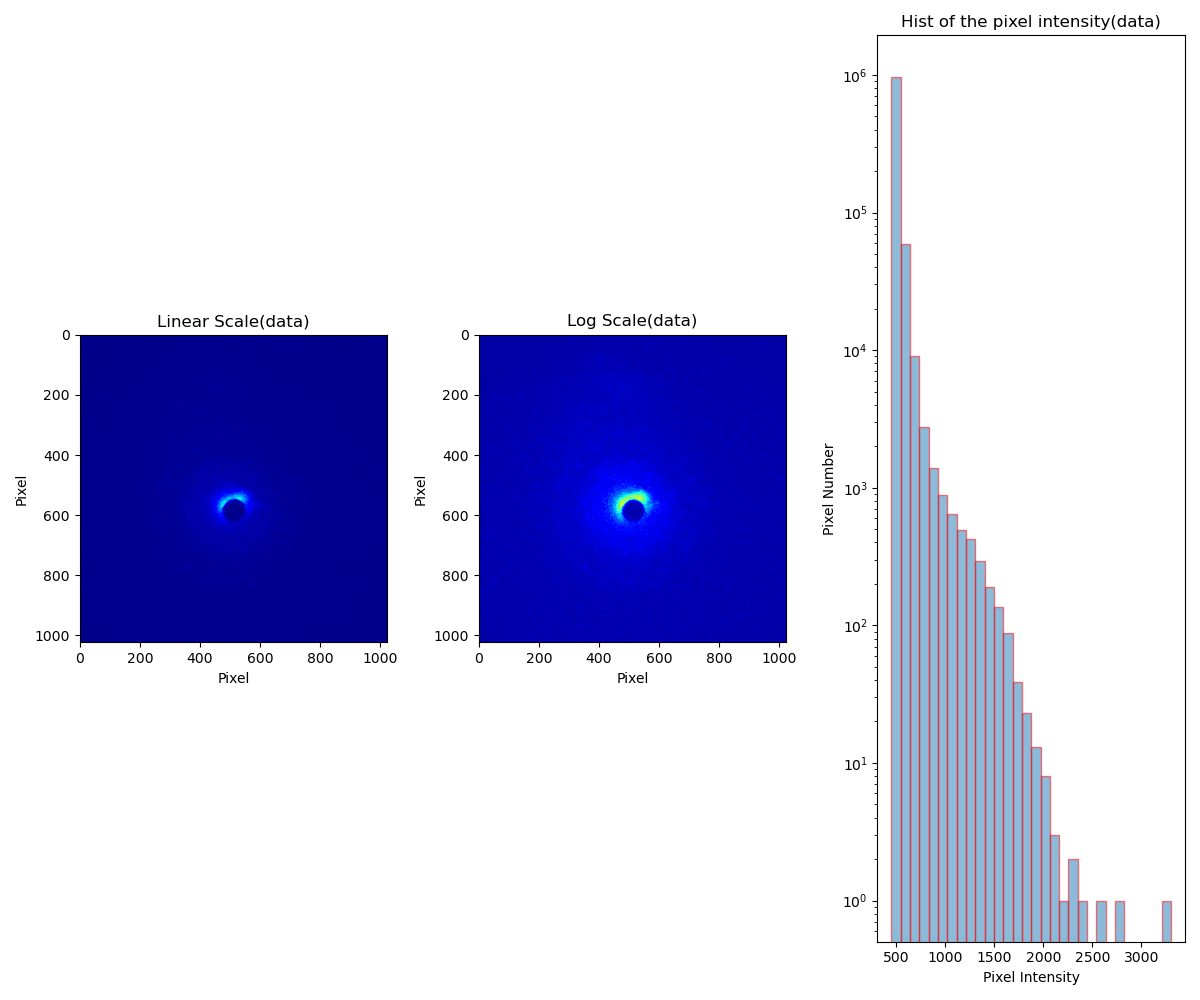

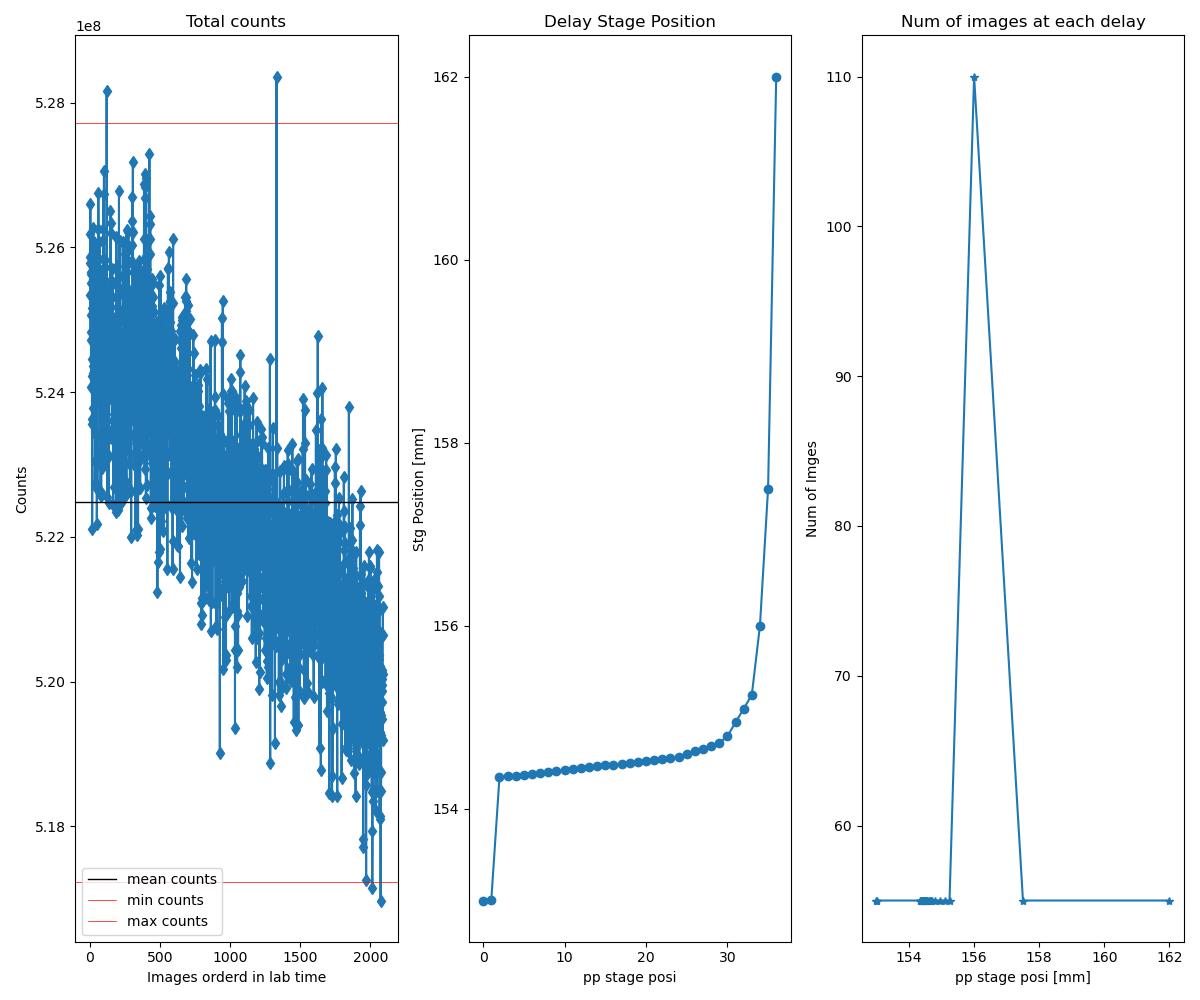

Image number read:  2090
Stage positions:  37
2090


In [4]:
# Using glob and * place holders to read in all file names from the specified path
#data_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\nitrophenyl code\\20180823\\Run\\'
data_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\nitrophenyl code\\20180623\\Run\\'
run_path = "*\\*\\ANDOR1_*.tif"

bkg_path = '\\work\\centurion\\shared\\UED_data\\FY18_o-nitrophenol\\20180823\\Background\\*\\*\\ANDOR1_*.tif'

full_path = data_path + run_path
#full_path = "D:\\UED_Data\\CP Images\\ANDOR1_*.tif"
print("Path to images ", full_path)
print("Path to background images ", bkg_path)

files = glob.glob(full_path)
bkg_files = glob.glob(bkg_path)
print("Number of files loaded: ", len(files))
print("Number of background files loaded: ", len(bkg_files))


print('Load diffraction signal');
data_array, stage_positions, file_order, counts = gued.get_image_details(files[:], sort=True, plot=True, filter_data=False)

counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position


print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage))
print(len(np.unique(file_order)))

## Remove Images with Bad Counts

In [5]:
help(gued.remove_counts)

Help on function remove_counts in module gued:

remove_counts(data_array, stage_positions, file_order, counts, added_range=[], std_factor=3, plot=False)
    Filters input parameters by removing any data where the total counts falls outside of the set filter. Default
    value is set to 3 standard deviations from the mean. Returns the same variables as it inputs but with
    different dimensions.
    
    ARGUMENTS:
    
    data_array (ndarray): 
        Multidimensional array of N x 1024 x 1024 where N is the length of file_names list
    stage_pos (array): 
        One dimensional array of length N containing the stage positions associated with each image.
    file_order (array): 
        One dimensional array of length N that reflects the order with which the images are taken.
    counts(ndarray): 
        One dimensional array of length N containing the total counts after summing over each array
        element.
    
    OPTIONAL ARGUMENTS:
    
    std_factor (int): 
        Defau

4  number of files removed from  2090  initial files


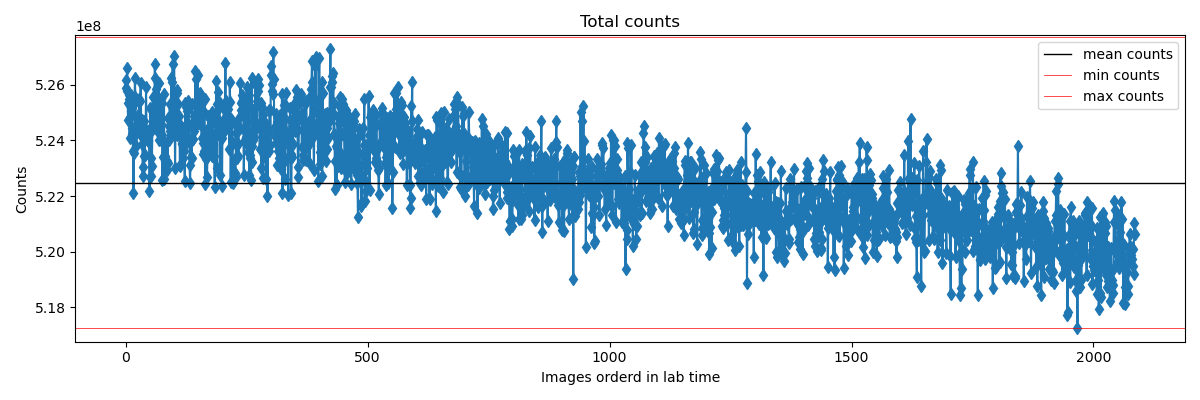

In [6]:
# Remove Outlier Images Based on Total Counts
data_array, stage_positions, file_order, counts = gued.remove_counts(data_array, stage_positions, file_order, counts, added_range=[], plot=True)


## Average Based on Stage Positions

In [7]:
stage_len = len(uni_stage);               #  Number of delays
ave_data = np.ones((stage_len,1024,1024));  # temporary array to be filled in


if stage_len>20:
    prt_count = 5
else:
    prt_count = 1  
for i in range(stage_len):
    if i%prt_count == 0:
        print(f'Averaging data at stage posi # {uni_stage[i]}') # Obtain a sub array to save the data in one delay
    stage_data = data_array[np.where(stage_positions==uni_stage[i])[0]]
    ave_data[i] = np.nanmean(stage_data,axis=0) #assign values to array

data_array = ave_data # renaming for ease and continuity
print(data_array.shape)

Averaging data at stage posi # 153.0
Averaging data at stage posi # 154.375
Averaging data at stage posi # 154.425
Averaging data at stage posi # 154.475
Averaging data at stage posi # 154.525
Averaging data at stage posi # 154.6
Averaging data at stage posi # 154.795
Averaging data at stage posi # 157.5
(37, 1024, 1024)


## Find Centers

First, adjust global variables using the `Set_up_Globals.ipynb` notebook to get centers accurately. Should not see center jumps more than one or two pixels. If this is happening you probably need to adjust global values

In [8]:
help(gued.find_center_pool)

Help on function find_center_pool in module gued:

find_center_pool(data_array, plot=True, print_stats=True)
    Finds center of each image in the data array using concurrent.futures.ThreadPoolExecutor to quickly process
    many data files.
    
    ARGUMENTS:
    
    data_array (ndarray): 
        array of image like data with shape Nx1024x1024
    
    OPTIONAL ARGUMENTS:
    
    plot (boolean): 
        Default is set to True. When true, plots an image of the values for center_x and center_y with respect to pixel number
    print_stats (boolean): 
        Default is set to True. Prints the average value for center_x and center_y and prints the percent failure rate.
    
    GLOBAL VARIABLES:
    
    CENTER_GUESS (tuple): 
        initial guess for center position
    RADIUS_GUESS (int): 
        initial guess for the radius
    DISK_RADIUS (int): 
        value for disk radius used in mapping
    
    RETURNS:
    
    center_x (array):
        One-dimensional array of x values 

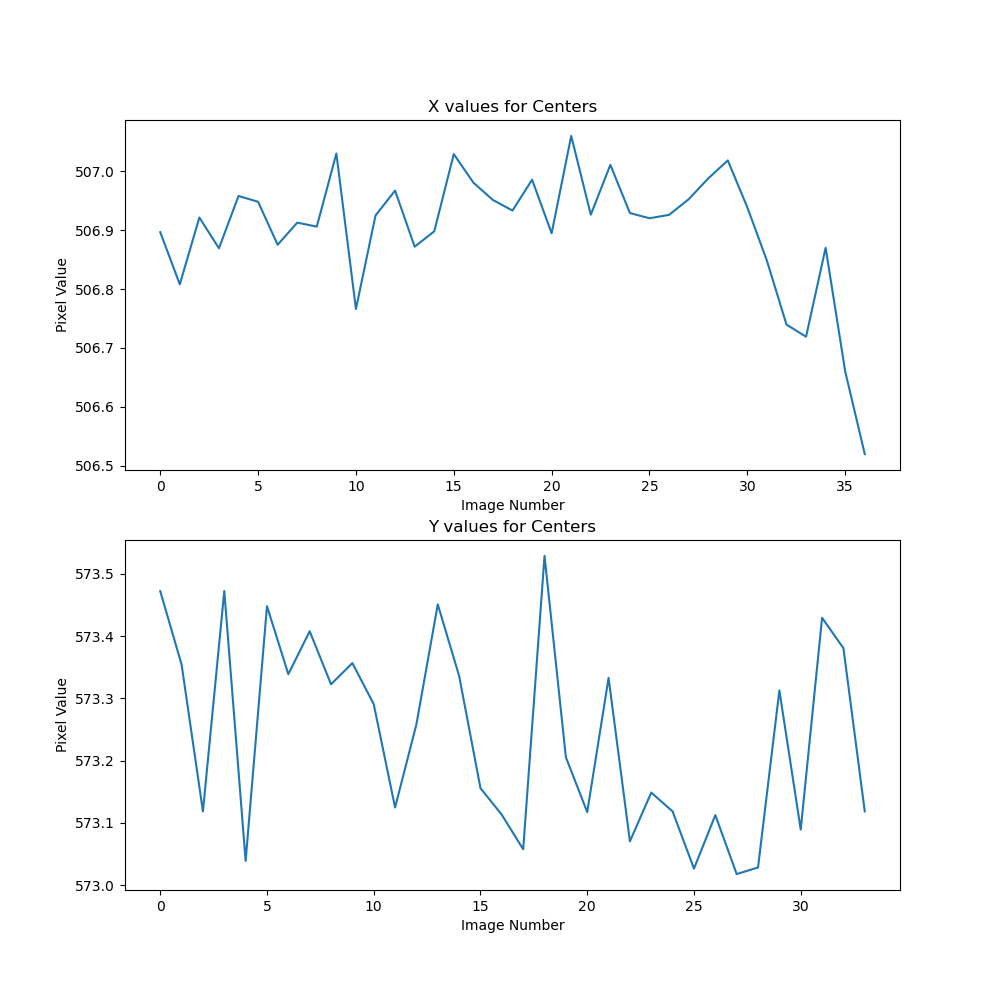

Averaged ctr is (506.901259763477, 573.2288747549721)
Percentage of images where the center finding failed (i.e., found the guess value): 0.0


In [9]:
# only works when done before other steps...
center_x, center_y = gued.find_center_pool(data_array, plot=True)

## Subtract Background

In [10]:
help(gued.remove_background_pool)

Help on function remove_background_pool in module gued:

remove_background_pool(data_array, remove_noise=True, plot=False)
    Removes the background of images based on the corners. Runs the hidden function _remove_background and runs it in parallel.
    
    ARGUMENTS:
    
    data_array (3d array): 
        data array of all images
    
    OPTIONAL ARGUMENTS:
    
    remove_noise (boolean): 
        Default set to true. Returns data array with noise removed. If false, only returns the interpolated background
    plot (boolean): 
        Default set to false. When true, plots an example of original data, interpolated background, and cleaned image.
    
    RETURNS:
    
    clean_data (3d array): 
        Original data with background removed when remove_noise==True
    or
    backgrounds (3d array):
        Interpolated background for each image when remove_noise==False



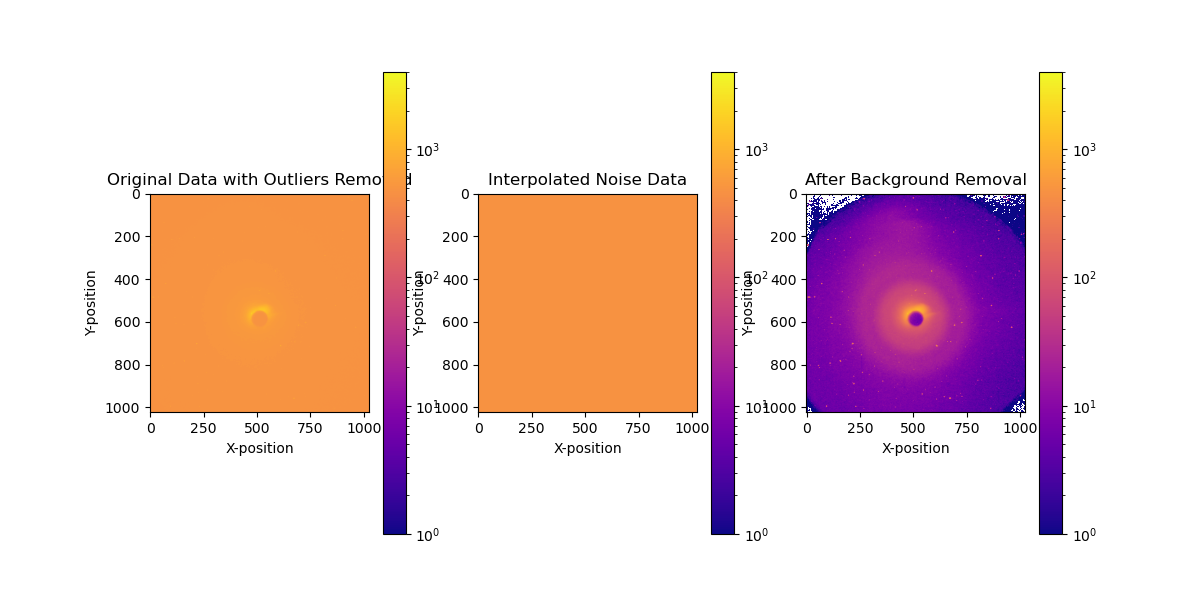

In [11]:
data_array = gued.remove_background_pool(data_array, remove_noise=True, plot=True)

## Remove Hot Pixels

In [12]:
help(gued.remove_xrays_pool)

Help on function remove_xrays_pool in module gued:

remove_xrays_pool(data_array, plot=True, std_factor=3)
    Filters out any pixels that are more than set threshold value based on the standard deviation of the
    average pixel value by running the hidden function _remove_xrays in parallel.
    
    ARGUMENTS:
    
    data_array (3d array): 
        array of image like data with length N where N is number of images.
    
    OPTIONAL ARGUMENTS:
    
    plot (boolean): 
        Default set to True. Plots the percentage of pixeled removed during cleaning process
    std_factor (int): 
        Default set to 3. Defines the threshold for removing pixels with |pixel_value - mean| > std_factor*std
    
    RETURNS:
    
    clean_data (3d array): 
        array of image like data with shape of input data array where errant pixels are now masked based on the set threshold



Removing hot pixels from all data


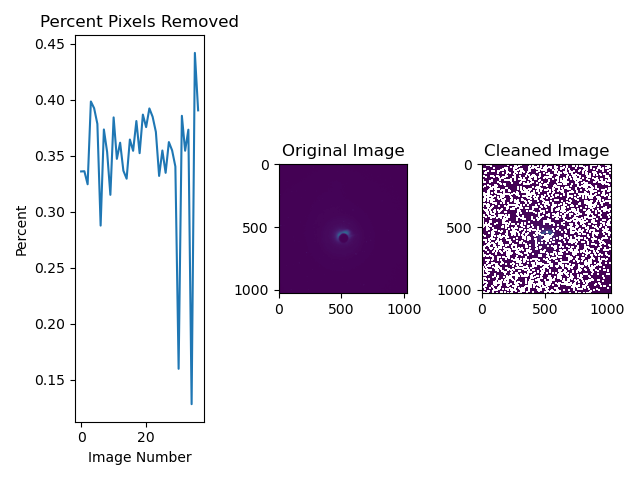

In [13]:
data_array = gued.remove_xrays_pool(data_array, plot=True)

## Mask Beam Block and Artifacts


In [14]:
help(gued.apply_mask)

Help on function apply_mask in module gued:

apply_mask(data_array, fill_value=nan, add_rectangular=False, plot=False)
    Applies a mask to individual images in the data array.
    
    ARGUMENTS:
    
    data_array_1d : 2D array
        Diffraction pattern.
    
    OPTIONAL ARUGMENTS:
    
    fill_value : int, float, or nan, optional
        Value that use to fill the area of the mask. The default is np.nan.
    add_rectangular : boolean, optional
        Additional mask with rectangular shape. The default is True.
    showingfigure : boolean, optional
        Show figure of the result of applied masks. The default is False.
    
    GLOBAL VARIABLES:
    
    MASK_CENTER : 1D array, tuple, or list that contains only two values
        Center for generating mask cover unscattered electron beam.
    MASK_RADIUS : int
        Radius of the mask.
    ADDED_MASK : list of 3-value-lists, optional
        Additional masks. Input gonna be [[x-center, y-center, radius], [...], ...] The de

c:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\Coding Lab Notebook\gued_package\GUED_Analysis\gued.py:992: RuntimeWarning: Mean of empty slice
  masked_mean = np.nanmean(masked_data, axis=0)


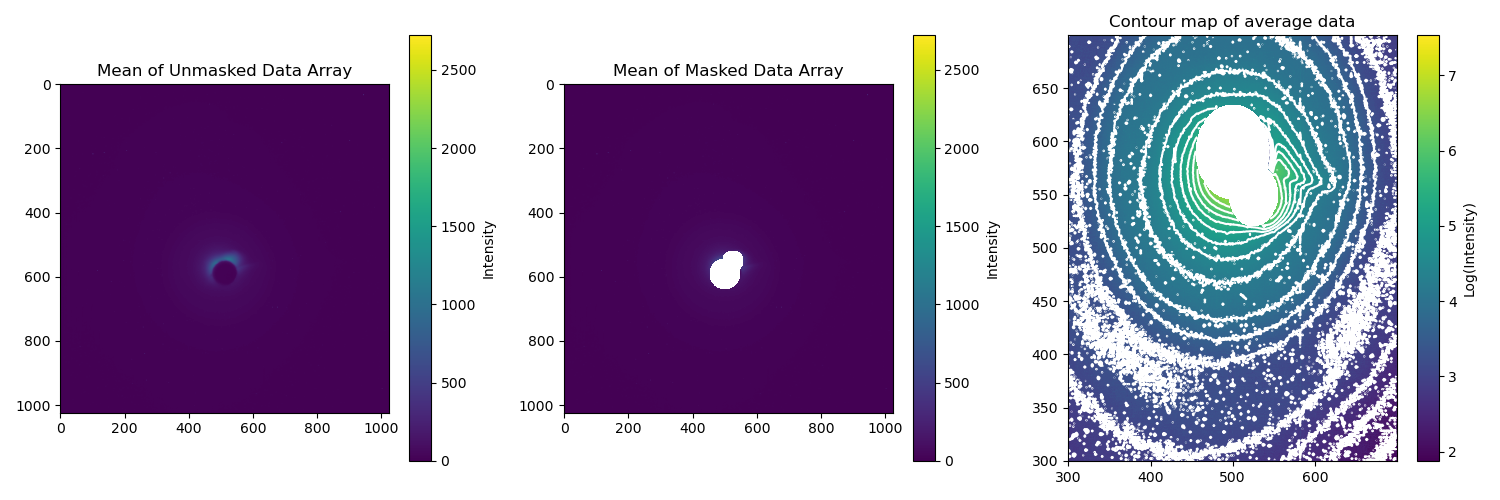

In [15]:
# Apply Mask
data_array = gued.apply_mask(data_array, plot=True)

## Remove Radial Outliers

In [16]:
help(gued.remove_radial_outliers_pool)

Help on function remove_radial_outliers_pool in module gued:

remove_radial_outliers_pool(data_array, centers, plot=False)
    Removes instances of outlier pixels based on the radial average of the image. Runs the hidden function _remove_radial_outliers in parallel. 
    Works by first converting an individual array to polar coordinates and remaps to create an average image. Then performs a logical check on 
    the original image compared to interpolated image. 
    
    ARGUMENTS: 
    
    data_array (3d array):
        Original data 
    center (list):
        Can either be an average center value of form [x, y] or a list of centers of form [[x1,y1], [x2, y2], ...]
    
    OPTIONAL ARGUMENTS: 
    
    plot (boolean):
        default set to False. When true, plots an example of original data, the interpolated average image, and the cleaned image
    
    RETURNS:
    
    clean_data (3d array):
        data with outliers removed



Using average center
Removing radial outliers from all data


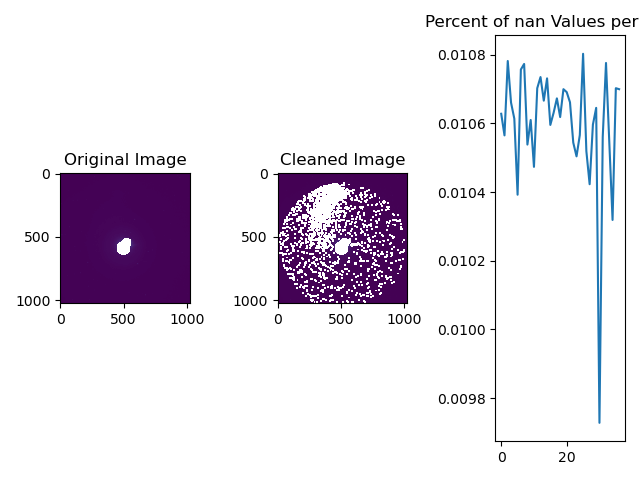

In [17]:
center = list(zip(center_x, center_y))
center = np.mean(center, axis=0)
cleaned_data = gued.remove_radial_outliers_pool(data_array, center, plot=True)

data_array = cleaned_data 
del cleaned_data
#print(center)

## Apply Median Filter

In [18]:
help(gued.median_filter_pool)

Help on function median_filter_pool in module gued:

median_filter_pool(data_array, plot=True)
    Takes in a large 3D array of data and applies the scipy.ndimage.median_filter on them in parallel processing using the hidden function
    _median_filter.
    
    ARGUMENTS: 
    
    data_array (3d array):
        array of all images
    
    OPTIONAL ARGUMENTS:
    
    plot(boolean): Default set to True
        When true, plots an example of the original and of the filtered image
    
    RETURNS: 
        
    filtered_data (3d array):
        filtered data array of the same size as the input array



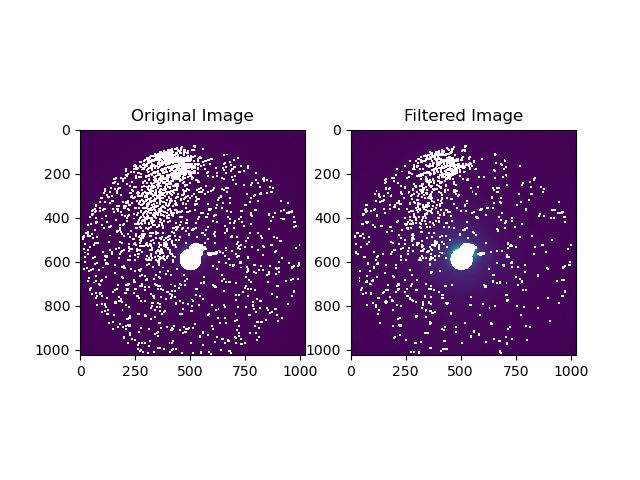

In [19]:
clean_data = gued.median_filter_pool(data_array, plot=True)

data_array = clean_data
del clean_data

## Get Azimuthal Average and Normalize

Using average center
Calculating azimuthal average for all data
maximum value previously: 450 -- length of array: 450


c:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\Coding Lab Notebook\gued_package\GUED_Analysis\gued.py:1609: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data_array2d, axis=0)


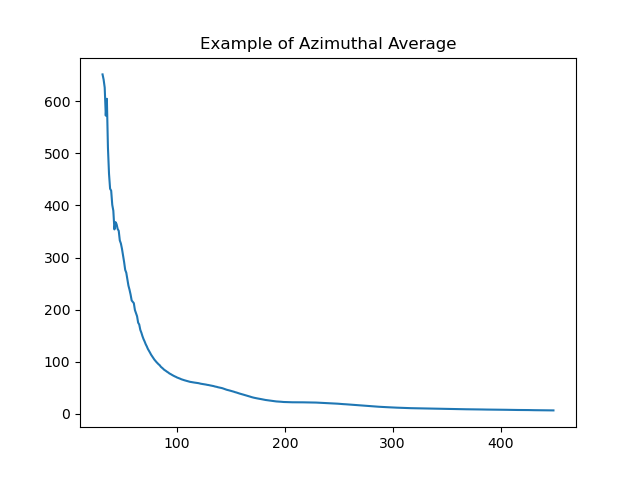

In [20]:
norm_data, norm_std = gued.get_azimuthal_average_pool(data_array, center, normalize=True, plot=True)

## Calculate Pump Probe Signal

C:\Users\laure\AppData\Local\Temp\ipykernel_4392\1816770356.py:14: RuntimeWarning: Mean of empty slice
  norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0
C:\Users\laure\AppData\Local\Temp\ipykernel_4392\1816770356.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


98


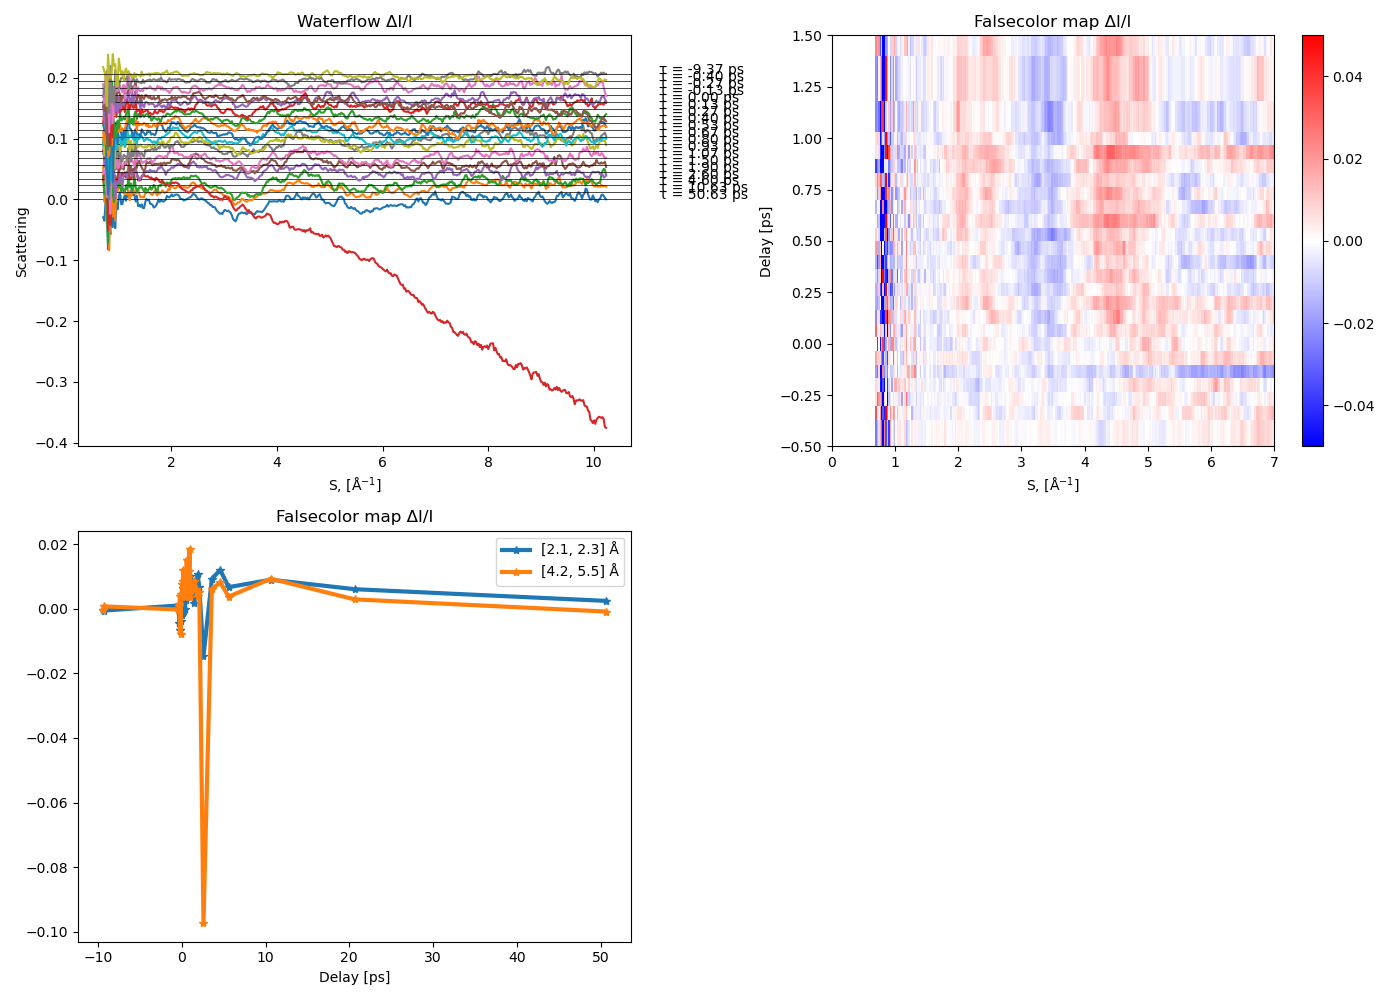

In [23]:
# (3) Plot the figure: Plot the time-dependent signal
angs = '\u00C5'; # angstrom sign
s_cali = 0.0228 # S calibration in experiment
#s_cali = 0.02134
posi_0    = 154.405 # The reference T0
#posi_0 = 108.61
s = np.arange(0,len(norm_data[0]))*s_cali # The Q axis
realtime = (uni_stage-posi_0)/0.15  # Delay axis in ps

if stage_len<5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 3
norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0

dI_I_norm = (norm_data-norm_ref)/norm_ref; # Calculate the percentage difference signal

# Plot a figure of the time-depdendent signal of scattering percentage difference.
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
for i in range(stage_len):
    if i%2 == 0:
        plt.plot(s,dI_I_norm[stage_len-i-1] + np.nanmax(dI_I_norm)*(i)/15);
        plt.text(s[-1]+1,np.nanmax(dI_I_norm)*(i)/15, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
        plt.axhline(y = np.nanmax(dI_I_norm)*(i)/15, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Scattering');plt.title('Waterflow ΔI/I');

plt.subplot(2,2,2)
plt.pcolor(s,realtime,dI_I_norm,cmap='bwr');
plt.clim(vmin=-0.05, vmax=0.05);
plt.colorbar()
plt.ylim(-0.5, 1.5)
plt.xlim(0, 7)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,3)
RoI_1 = [2.1, 2.3];
RoI_2 = [4.2, 5.5];
print(round(RoI_1[0]/0.0215))
Inte_1 = dI_I_norm[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
Inte_2 = dI_I_norm[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
plt.plot(realtime,Inte_1,'-*',linewidth=3,label=str(RoI_1)+' '+angs);
plt.plot(realtime,Inte_2,'-*',linewidth=3,label=str(RoI_2)+' '+angs);
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.tight_layout()
plt.show()


## Power Fit Data

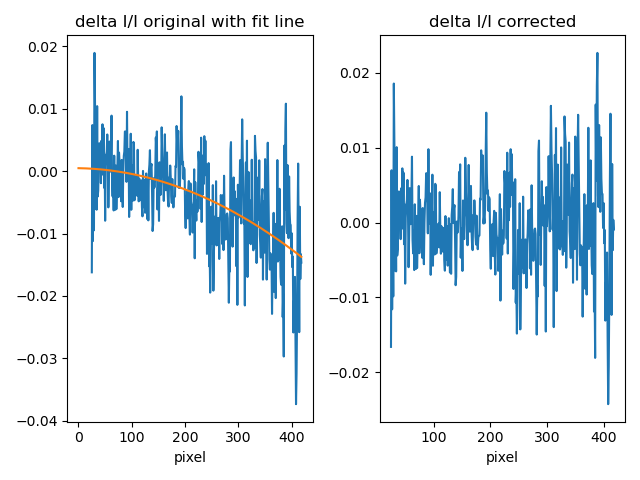

C:\Users\laure\AppData\Local\Temp\ipykernel_14760\3549677952.py:2: RuntimeWarning: Mean of empty slice
  dI_I_ave = np.nanmean(dI_I_norm, axis=0)
C:\Users\laure\AppData\Local\Temp\ipykernel_14760\3549677952.py:3: RuntimeWarning: Mean of empty slice
  corrected_ave = np.nanmean(corrected_dI, axis=0)


In [21]:
corrected_dI, baseline2d = gued.poly_fit(dI_I_norm, s, return_baseline=True)
dI_I_ave = np.nanmean(dI_I_norm, axis=0)
corrected_ave = np.nanmean(corrected_dI, axis=0)
baseline_ave = np.nanmean(baseline2d, axis=0)

### Plot with Error Bars

C:\Users\laure\AppData\Local\Temp\ipykernel_14760\4099487424.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


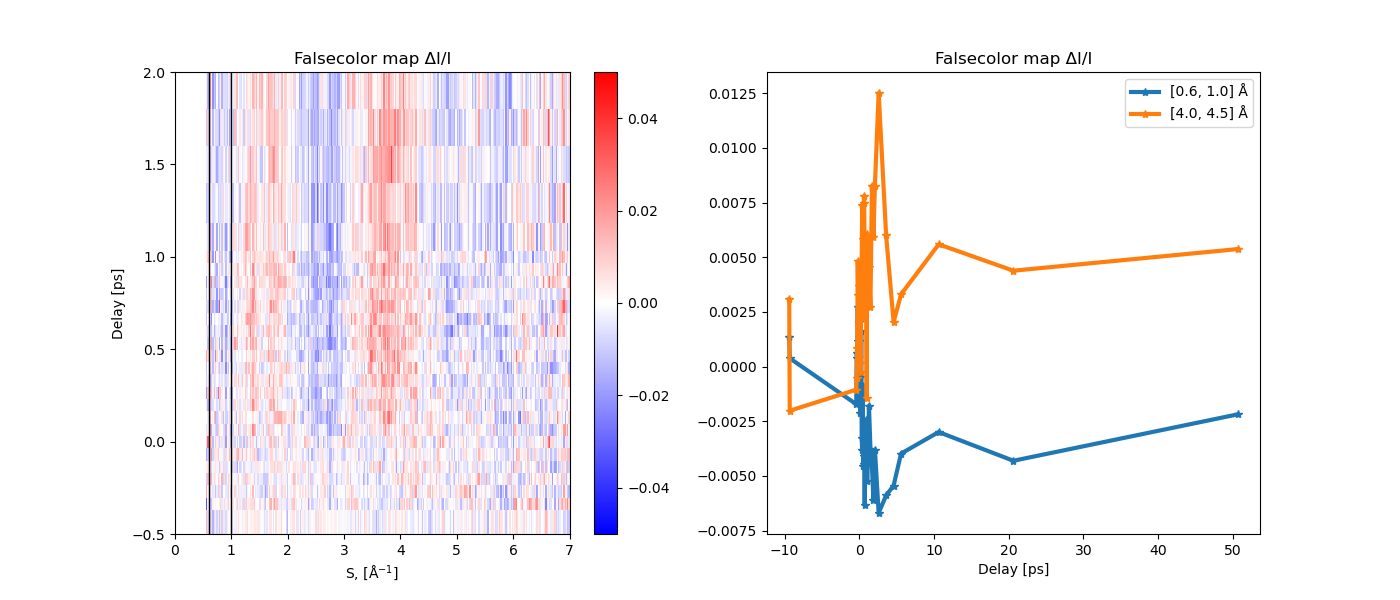

In [25]:
RoI_1 = [0.6, 1.0]
RoI_2 = [4.0, 4.5]
RoI_3 = [2.0, 2.5]

Inte_1 = corrected_dI[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = corrected_dI[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1)
Inte_2 = corrected_dI[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
std_2 = corrected_dI[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].std(axis=1);
Inte_3 = corrected_dI[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].mean(axis=1);
std_3 = corrected_dI[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].std(axis=1);

plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
plt.pcolor(s,realtime,corrected_dI,cmap='bwr');
plt.axvline(x = RoI_1[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_1[1], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_2[0], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_2[1], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_3[0], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_3[1], color = 'k', linestyle = '-',linewidth=1);
plt.clim(vmin=-0.05, vmax=0.05);
plt.colorbar()
plt.ylim(-0.5, 2)
#plt.ylim(154.35, 154.6)
plt.xlim(0,7)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.subplot(1,2,2)

plt.plot(realtime,Inte_1,'-*',linewidth=3,label=str(RoI_1)+' '+angs)
plt.plot(realtime,Inte_2,'-*',linewidth=3,label=str(RoI_2)+' '+angs)
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.show()

## Save Data 

In [28]:
exp_label = "o-ntph_data_fast_analysis"
today = date.today()
print(today)

file_name = f"{exp_label}_{today}.h5"
print(file_name)
group_name = "s4"
run_number = 1 # arbitrary number representing a fraction of total data. Update run_number each time

gued.save_data(file_name, group_name, norm_data, stage_positions, run_number)

2024-06-13
o-ntph_data_fast_analysis_2024-06-13.h5
Run 1 data saved successfully.


# Next Steps

If you're running an experiment and want to monitor for drifts in the data move to the `Tracking_Center.ipynb` notebook. This notebook is also useful for optimizing the center finding code __before__ running the `process_all.py` program.

You're now ready to clean all the data without averaging. This process is significantly slower and requires a balancing act between computer processing and required memory. I've found that, for 2000 images, it takes 25 minutes to process 10 sets of 200 images. Looping over subgroups helps reduce the required memory storage and prevents crashing. See the `process_all.py` file to set up the code for processing all images. Make sure to adjust the `exp_label` and `group_name` variables for proper saving. 
